# SpaceNet EDA Begins
- You can check Observation at the bottom of the notebook.

## Installing Dependincies and Importinf libraries

In [ ]:
%%capture
!pip install boto3
!pip install awscli
!pip install --upgrade awscli
!pip install rasterio
!pip install geopandas
!pip install boto3
!pip3 install folium
!pip install selenium
!pip install PyCRS

In [ ]:
import json
import os
import PIL
import rasterio as rio
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import boto3
import folium
from folium import plugins
import fiona

##  Downloading the sample dataset









In [ ]:
# Download the samples
%%capture
!aws s3 cp 's3://spacenet-dataset/spacenet/SN4_buildings/sample/' SpaceNetSample/ --recursive --no-sign-request

In [ ]:
# Helper functions for visualization
def visualize(list_images):
    """PLot images in row X columns"""
    n = len(list_images)
    fig=plt.figure(figsize=(25, 25))
    columns = 3
    rows = np.ceil(n/columns)
    for i, image in enumerate(list_images):
        fig.add_subplot(rows, columns, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(image)
    plt.show()
# Create RGB version for the images
def get_rgb(raster_img):
  '''
  takes a path contaioning mas image 
  and returns the rgb version
  '''
  red = rio.open(raster_img).read(3) 
  green = rio.open(raster_img).read(2) 
  blue = rio.open(raster_img).read(1) 

  rgb = np.dstack((red, green, blue))
  # normalize and convert to range 0-255
  rgb = ((rgb - rgb.min()) / (rgb.max() - rgb.min()) * 255).astype('uint8')
  return rgb


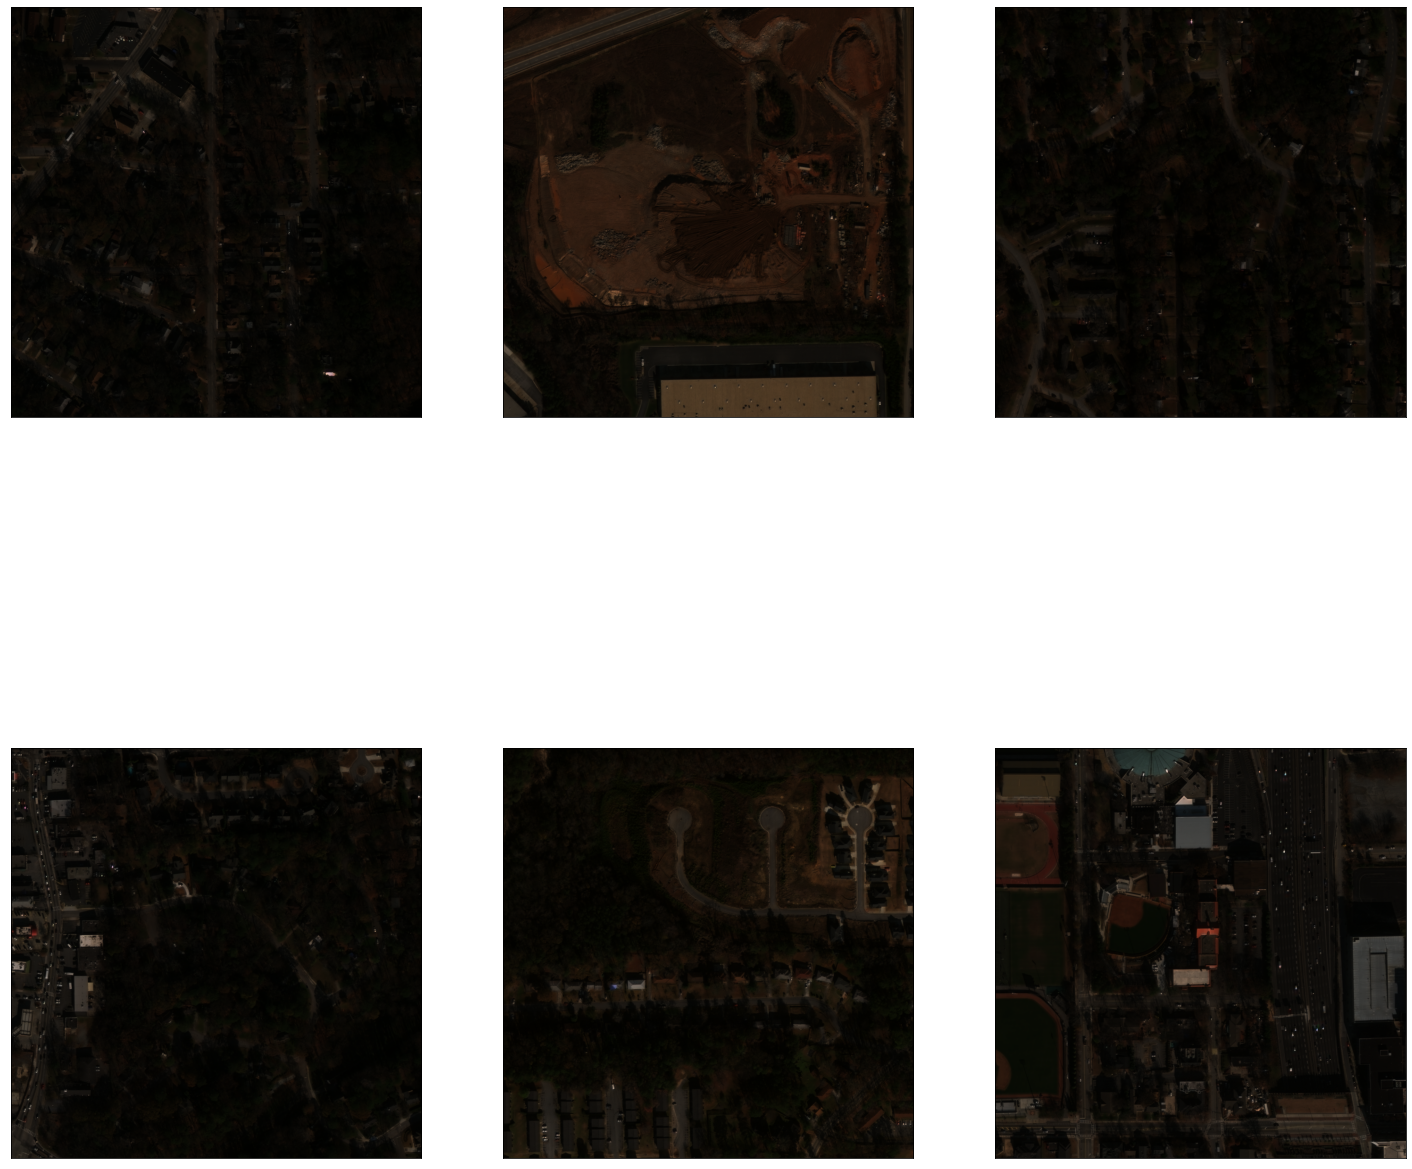

In [ ]:
# For the first Image folder
root = '/content/SpaceNetSample/Atlanta_nadir7_catid_1030010003D22F00'
img_root = os.path.join(root, 'Pan-Sharpen')
imgs = []
for img in sorted(os.listdir(img_root)):
  img = get_rgb(os.path.join(img_root, img))
  imgs.append(img)

# Inspect the images
visualize(imgs[5:11])

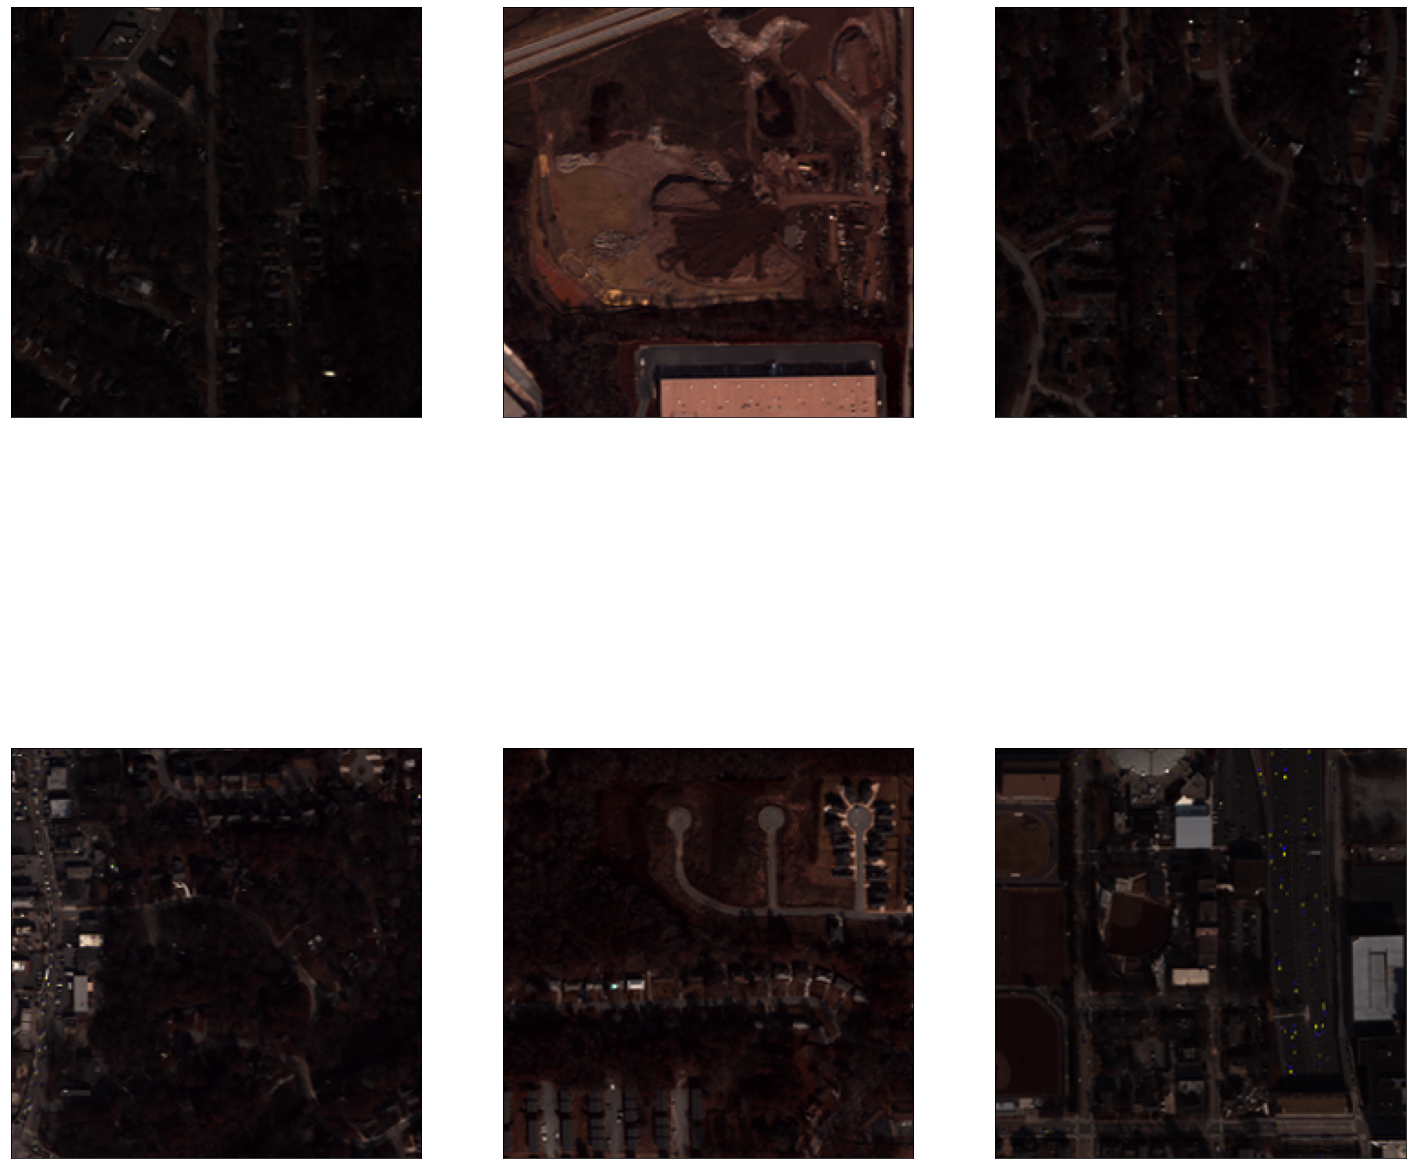

In [ ]:
img_root = os.path.join(root, 'MS')
imgs = []
for img in sorted(os.listdir(img_root)):
  img = get_rgb(os.path.join(img_root, img))
  imgs.append(img)

# Inspect the images
visualize(imgs[5:11])

Number of bands 1
Image dimenssion: 900X900 pixel


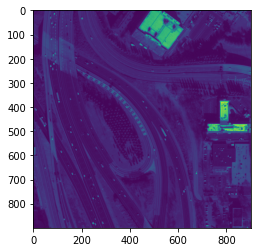

In [ ]:
# Read the PAN version
pan_img = rio.open('/content/SpaceNetSample/Atlanta_nadir10_catid_1030010003993E00/PAN/PAN_Atlanta_nadir10_catid_1030010003993E00_741251_3742239.tif')
num_bands = len(pan_img.descriptions)
print(f"Number of bands {num_bands}")
print(F"Image dimenssion: {pan_img.height}X{pan_img.width} pixel")
plt.imshow(pan_img.read(1))


Number of bands for the Sharpen Pans4


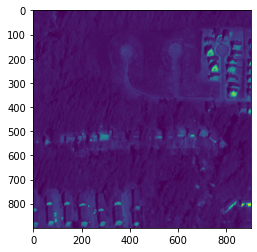

In [ ]:
# Read the SPAN version (Low-res color bands + High-res grayscale band = Hi-res color image)
span_img = rio.open('/content/SpaceNetSample/Atlanta_nadir50_catid_10300100039E6200/Pan-Sharpen/Pan-Sharpen_Atlanta_nadir50_catid_10300100039E6200_741251_3730089.tif')
num_bands = len(span_img.descriptions)
print(f"Number of bands for the Sharpen Pans{num_bands}")
plt.imshow(span_img.read(1))

In [ ]:
target = gpd.read_file('/content/SpaceNetSample/geojson/spacenet-buildings/spacenet-buildings_741251_3730089.geojson')

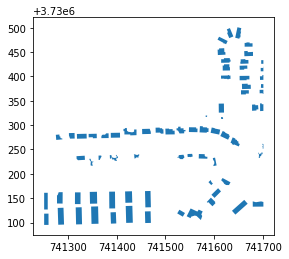

In [ ]:
target.plot()

In [ ]:
target.head()

access  ...                                           geometry
0         ...  POLYGON ((741617.553 3730287.991, 741622.896 3...
1         ...  POLYGON ((741387.715 3730284.089, 741406.626 3...
2         ...  POLYGON ((741413.822 3730292.272, 741416.160 3...
3         ...  POLYGON ((741499.793 3730292.743, 741507.361 3...
4         ...  POLYGON ((741452.043 3730292.138, 741467.641 3...

[5 rows x 74 columns]

In [ ]:
t = target.loc[0,'geometry']
geocord= np.array(t.exterior.coords)

In [ ]:
geocord

array([[ 741617.55283352, 3730287.99115267],
       [ 741622.89606537, 3730285.46236065],
       [ 741622.44669503, 3730284.51871924],
       [ 741630.76626427, 3730280.600045  ],
       [ 741629.98218504, 3730278.9487304 ],
       [ 741632.23585959, 3730277.8846606 ],
       [ 741628.52595691, 3730270.11064915],
       [ 741612.60947046, 3730277.62219332],
       [ 741617.55283352, 3730287.99115267]])

In [ ]:
for i in geocord:
  print(i[1])

3730287.991152668
3730285.462360653
3730284.518719244
3730280.6000450035
3730278.9487303966
3730277.8846606044
3730270.1106491466
3730277.6221933197
3730287.991152668


In [ ]:
target.crs

<Projected CRS: EPSG:32616>
Name: WGS 84 / UTM zone 16N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 90°W and 84°W, northern hemisphere between equator and 84°N, onshore and offshore. Belize. Canada - Manitoba; Nunavut; Ontario. Costa Rica. Cuba. Ecuador - Galapagos. El Salvador. Guatemala. Honduras. Mexico. Nicaragua. United States (USA).
- bounds: (-90.0, 0.0, -84.0, 84.0)
Coordinate Operation:
- name: UTM zone 16N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
span_img.crs

CRS.from_epsg(32616)

In [ ]:
the_img = get_rgb('/content/SpaceNetSample/Atlanta_nadir50_catid_10300100039E6200/Pan-Sharpen/Pan-Sharpen_Atlanta_nadir50_catid_10300100039E6200_741251_3730089.tif')

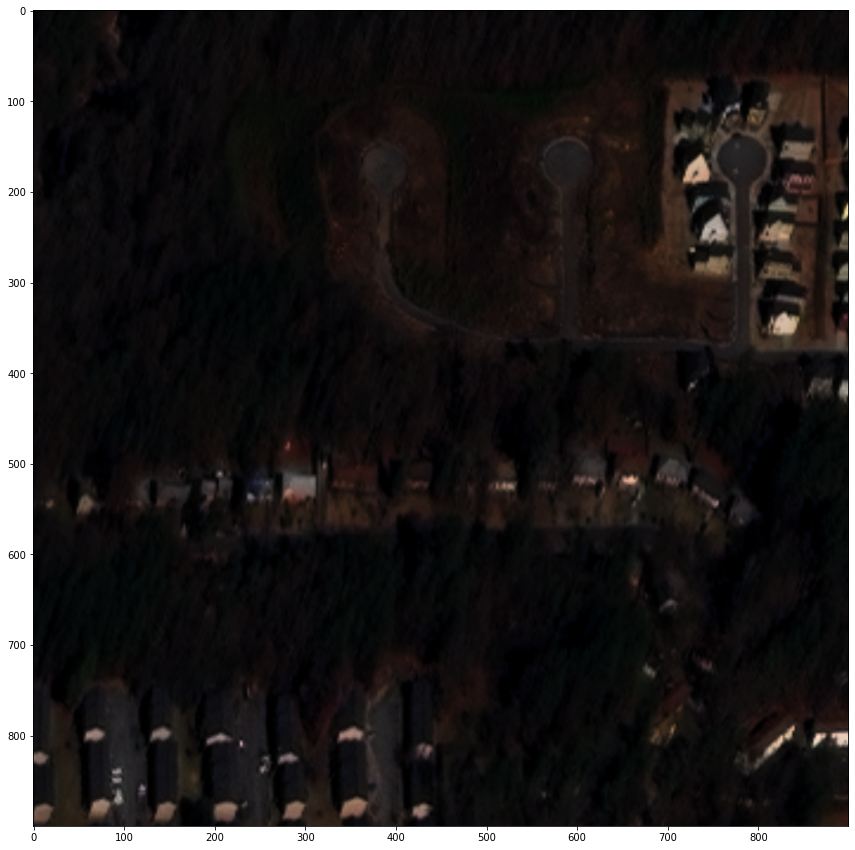

In [ ]:
plt.figure(figsize=(15,15 ))

plt.imshow(the_img)

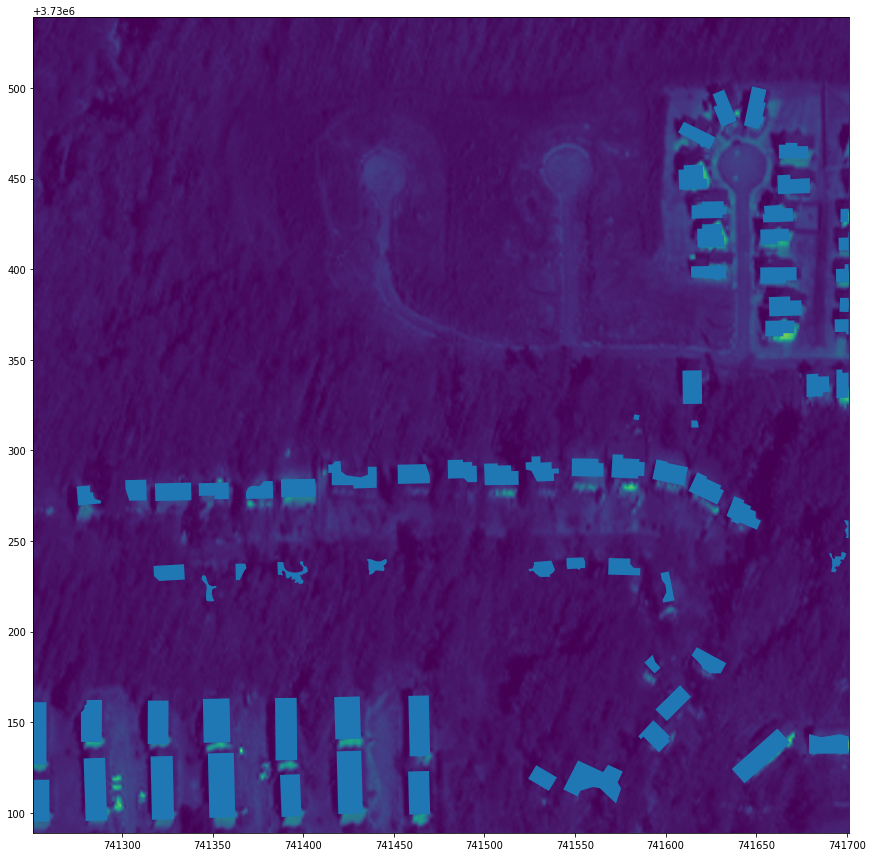

In [ ]:
import rasterio.plot
fig, ax = plt.subplots(figsize=(15, 15))
rasterio.plot.show(span_img,ax=ax)
target.plot(ax=ax)

In [ ]:


from rasterio.mask import mask
# the polygon GeoJSON geometry
geoms = target['geometry']
# load the raster, mask it by the polygon and crop it
with rio.open("/content/SpaceNetSample/Atlanta_nadir50_catid_10300100039E6200/MS/MS_Atlanta_nadir50_catid_10300100039E6200_741251_3730089.tif") as src:
    out_image, out_transform = mask(src, geoms, crop=True)
out_meta = src.meta.copy()

# save the resulting raster  
out_meta.update({"driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
"transform": out_transform})

with rio.open("masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

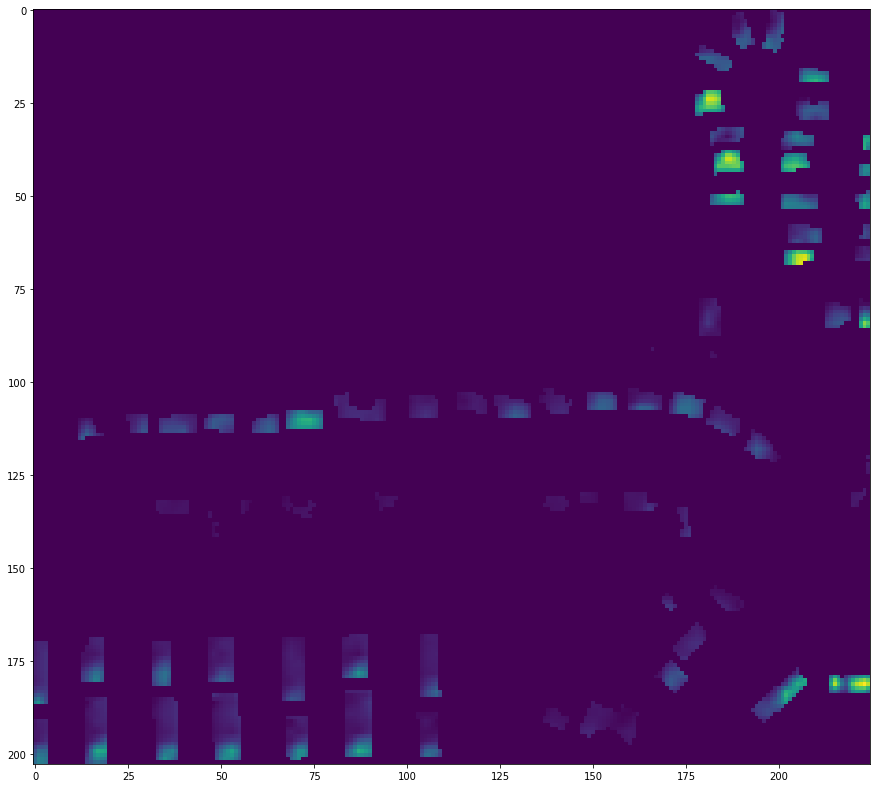

In [ ]:
masked = rio.open('/content/masked.tif')
plt.figure(figsize=(15,15))
plt.imshow(masked.read(3))

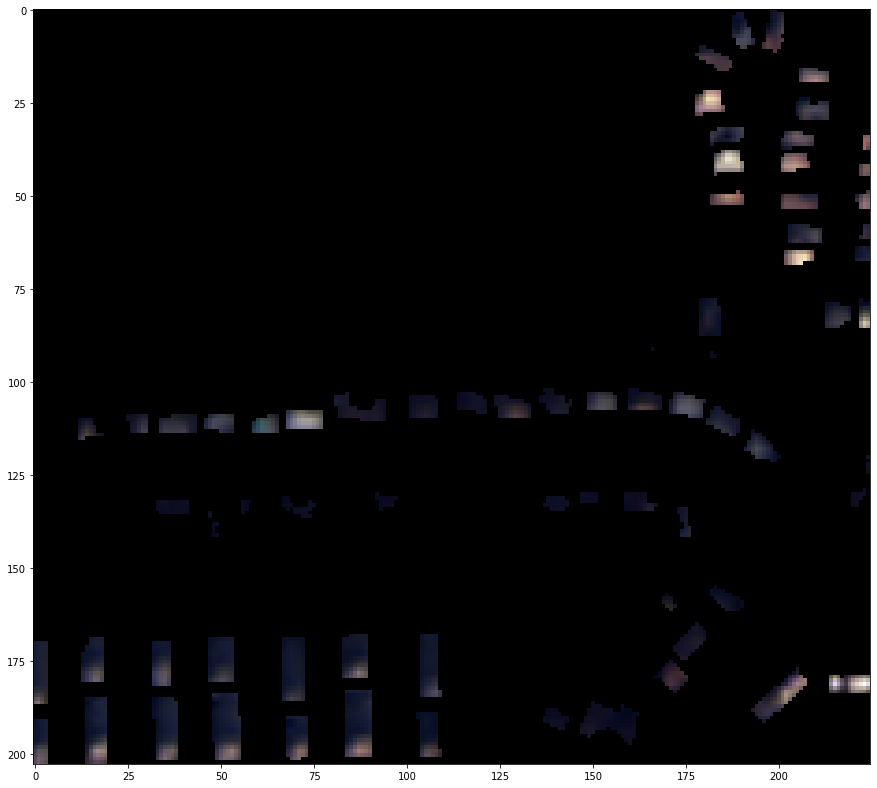

In [ ]:
masked_img=get_rgb("/content/masked.tif")
plt.figure(figsize=(15,15))
plt.imshow(masked_img)

In [ ]:
geo=target.iloc[0,:]
type(geo)

pandas.core.series.Series

In [ ]:
span_img.meta

{'count': 4,
 'crs': CRS.from_epsg(32616),
 'driver': 'GTiff',
 'dtype': 'uint16',
 'height': 900,
 'nodata': 0.0,
 'transform': Affine(0.5, 0.0, 741251.0,
       0.0, -0.5, 3730539.0),
 'width': 900}

In [ ]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][8]['geometry']]


In [ ]:
coords = getFeatures(target)
print(coords)

[{'type': 'Polygon', 'coordinates': [[[741548.3009269475, 3730295.6435497915], [741562.9763188277, 3730295.3924546265], [741562.9339585346, 3730293.0273518832], [741565.7648507023, 3730292.987823995], [741565.6284660577, 3730285.526022062], [741548.13115731, 3730285.827972129], [741548.3009269475, 3730295.6435497915]]]}]


In [ ]:
out_img, out_transform = mask(span_img, shapes=coords, crop=True)
out_meta = span_img.meta.copy()
epsg_code = int(span_img.crs.data['init'][5:])
print(epsg_code)


32616


In [ ]:
out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "crs":epsg_code})

In [ ]:
with rasterio.open("mask8.tif", "w", **out_meta) as dest:
        dest.write(out_img)


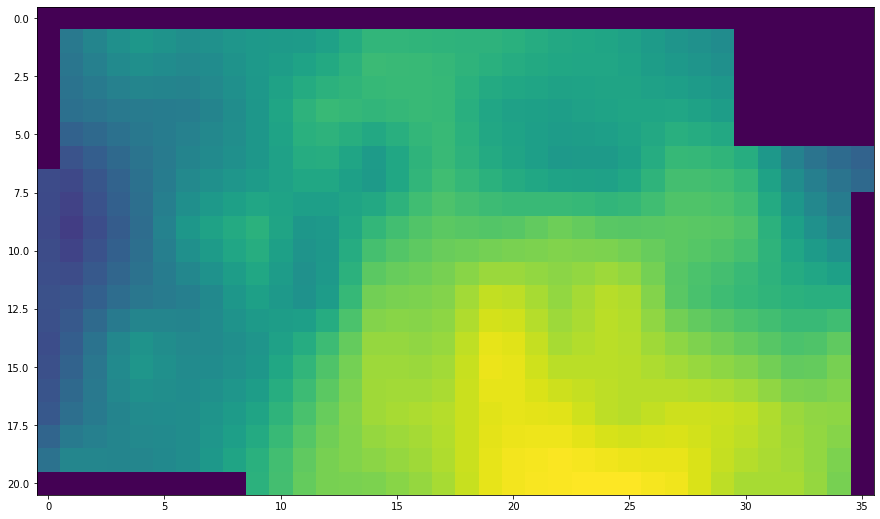

In [ ]:
masked = rio.open('/content/mask8.tif')
plt.figure(figsize=(15,15))
plt.imshow(masked.read(3))

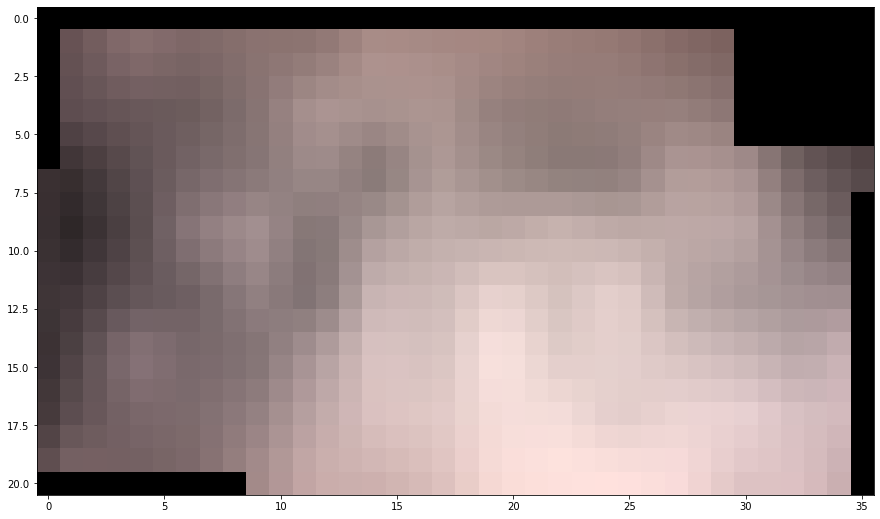

In [ ]:
masked_img=get_rgb("/content/mask8.tif")
plt.figure(figsize=(15,15))
plt.imshow(masked_img)

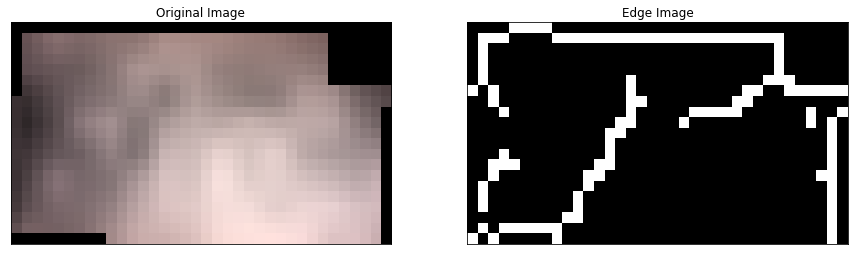

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

edges = cv2.Canny(masked_img,100,200)
plt.figure(figsize=(15,15))
plt.subplot(121),plt.imshow(masked_img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()


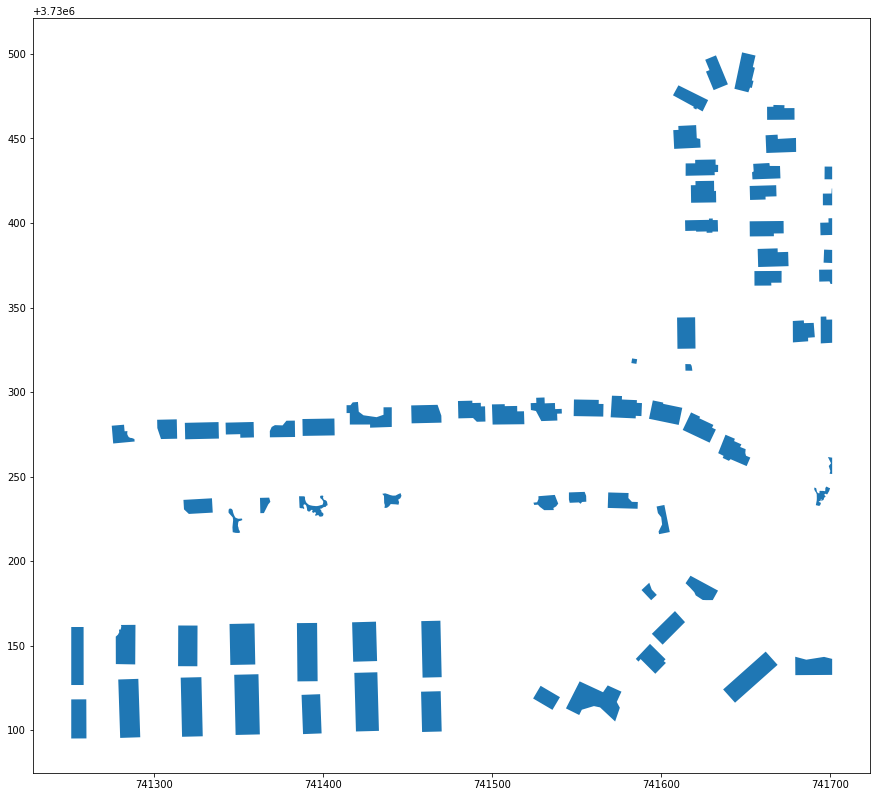

In [ ]:

target.plot(figsize=(15,15))